In [1]:
import os
import sys
import tifffile as tiff
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

sys.path.append("/home/phillip/documents/lysozyme")
import src
from src.lysozyme_stain_quantification.crypts.identify_potential_crypts_ import identify_potential_crypts

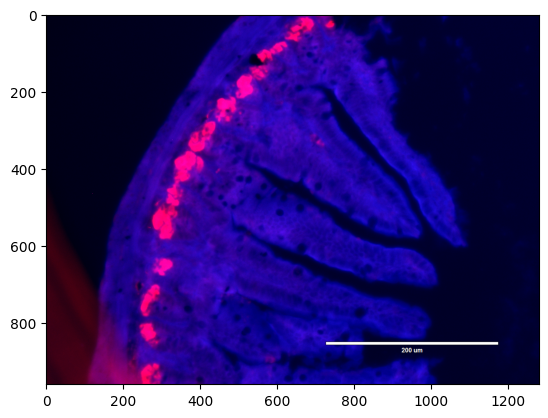

In [75]:

from src.lysozyme_stain_quantification.crypts.remove_edge_touching_regions_mod import remove_edge_touching_regions_sk
from src.lysozyme_stain_quantification.crypts.scoring_selector_mod import scoring_selector

max_regions = 8
image = tiff.imread("/home/phillip/documents/lysozyme/lysozyme images/Jej LYZ/G2/G2FL - 3.tif")
plt.imshow(image)

In [89]:

rfp = image[...,0]
dapi = image[...,2]


regions = remove_edge_touching_regions_sk(identify_potential_crypts(
    crypt_img=rfp,
    tissue_image=dapi,
    blob_size_px=int(50.0 * 0.4476),

))


In [211]:
weights = {
        "circularity": 0.35,  # Most important - want circular regions
        "area": 0.15,         # Second - want consistent sizes
        "line_fit": 0.25,     # Moderate - want aligned regions
        "red_intensity": 0.35,  # Moderate - want bright regions
        
        }
best_crypts, crypt_scores = scoring_selector(
        label_img=regions,
        raw_img=rfp,
        max_regions=max_regions,
        return_details=True,
        weights=weights
    )
#print(crypt_scores['properties_df'])

_, crypt_scores = scoring_selector(
        label_img=best_crypts,
        raw_img=rfp,
        max_regions=False,
        return_details=True,
        weights=weights
    )
print(crypt_scores['properties_df']['quality_score'])

0    0.187881
1    0.192713
2    0.231117
3    0.275234
4    0.304705
5    0.307251
6    0.384609
7    0.431553
Name: quality_score, dtype: float64


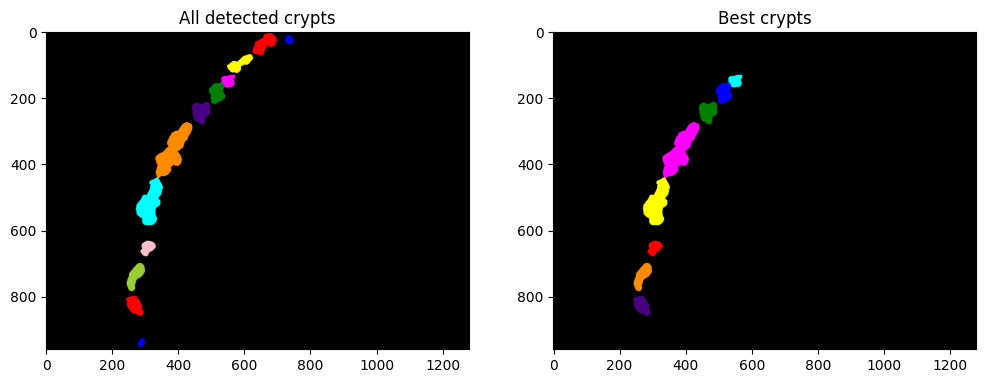

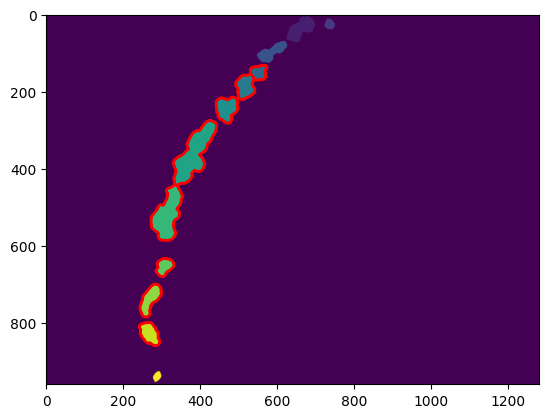

In [93]:
from skimage.color import label2rgb 
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(label2rgb(regions)); ax[0].set_title("All detected crypts")
ax[1].imshow(label2rgb(best_crypts)); ax[1].set_title("Best crypts")
plt.show()
from skimage.segmentation import find_boundaries
boundaries = find_boundaries(best_crypts)
subject = np.zeros_like(image)
subject[boundaries] = [255,0,0]
plt.imshow(regions)
plt.contour(boundaries, colors='r')

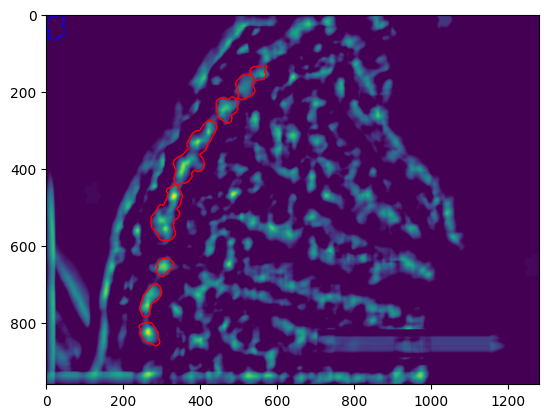

In [94]:
import scipy.ndimage as ndi
from skimage.feature import match_template
from skimage.restoration import inpaint

crypt_index = 2  # Index of the crypt to match
subject = rfp  # Image in which to search for matches

def minmax256(arr: np.ndarray):
    arr = arr.astype(np.float32)
    arr = (255*(arr - np.min(arr)) / (np.max(arr) - np.min(arr)) )
    return arr.astype(np.uint8)
def quantify_matches(detections: np.ndarray, index: int, src: np.ndarray, pad_input=True):
    #template_boundaries = find_boundaries(detections == index)
    slc = ndi.find_objects(detections == index)[0]

    crypt_binary = detections == index if src.ndim == 2 else np.stack([detections == index]*src.shape[-1], axis=-1)
    template = np.where(crypt_binary, src, np.zeros_like(src))
    template = template[slc]
    result = match_template(src, template, pad_input=pad_input)
    
    result = inpaint.inpaint_biharmonic(result, detections == index, channel_axis=None)
    result = np.maximum(result, 0)  # Collapse channel axis if present
    result = minmax256(result) # Normalize to 255
    result = result.astype(np.uint8)
    return result, template, slc

result, template, slc = quantify_matches(best_crypts, crypt_index, subject, pad_input=True)



plt.imshow(result)
plt.contour(find_boundaries(best_crypts), colors='r', linewidths=0.5)
plt.contour(find_boundaries(best_crypts[slc]), colors='b', linewidths=0.5)
plt.show()



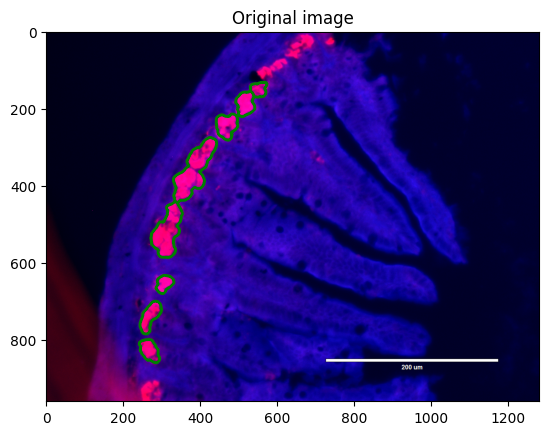

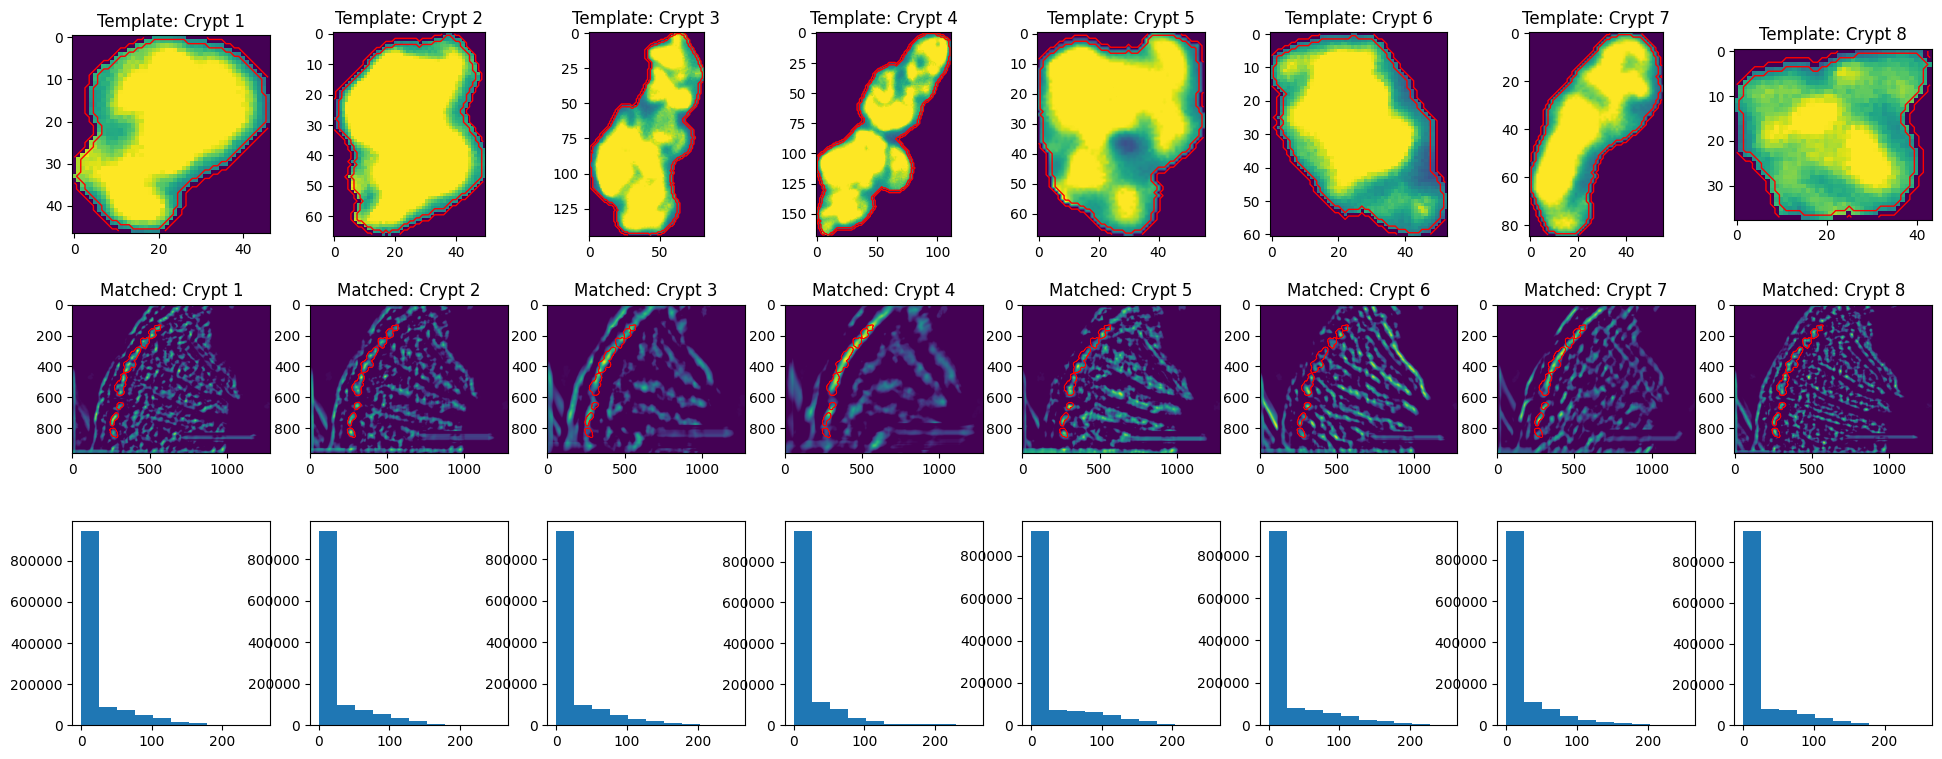

In [221]:
import scipy.ndimage as ndi
from skimage.feature import match_template
from skimage.segmentation import mark_boundaries


# show original image
plt.imshow(image)
plt.title("Original image")
plt.contour(find_boundaries(best_crypts), colors='g')
plt.show()
num_crypts = np.max(best_crypts)



match_indexes = []
def minmax256(arr: np.ndarray):
    arr = arr.astype(np.float32)
    arr = (255*(arr - np.min(arr)) / (np.max(arr) - np.min(arr)) )
    return arr.astype(np.uint8)
def quantify_matches(detections: np.ndarray, index: int, matching_image: np.ndarray[np.uint], pad_input=True):
    #template_boundaries = find_boundaries(detections == index)
    slc = ndi.find_objects(detections == index)[0]

    crypt_binary = detections == index if matching_image.ndim == 2 else np.stack([detections == index]*matching_image.shape[-1], axis=-1)
    template = np.where(crypt_binary, matching_image, np.zeros_like(matching_image))
    template = template[slc]
    result = match_template(matching_image, template, pad_input=pad_input)
    
    result = inpaint.inpaint_biharmonic(result, detections == index, channel_axis=None)
    result = np.maximum(result, 0)  # Collapse channel axis if present
    result = minmax256(result) # Normalize to 255
    result = result.astype(np.uint16)
    return result, template, slc
def create_match_stack(best_crypts, matching_image)-> tuple[np.ndarray[np.int_], list[tuple[slice,...]]]:
    match_arrays = []
    slcs = []
    for crypt_index in range(1, np.max(best_crypts)+1):
        result, template, slc = quantify_matches(best_crypts, crypt_index, matching_image, pad_input=True)
        match_arrays.append(result)
        slcs.append(slc)

    return match_arrays, slcs 

subject = rfp
result_stack, slcs = create_match_stack(best_crypts, subject)
avg_results = np.average(result_stack, axis=0)
collapsed_results =np.multiply.reduce(result_stack)


fig, ax = plt.subplots(3,num_crypts, figsize=(3*len(result_stack),9))
subject = rfp
boundaries = find_boundaries(best_crypts)


for crypt_index, (match_array, slc) in enumerate(zip(result_stack, slcs)):

    
    
    
    #ax[crypt_index, 0].imshow(mark_boundaries(subject, best_crypts==(crypt_index+1))[slc])
    ax[0, crypt_index].imshow(np.where(best_crypts==(crypt_index+1), subject, 0)[slc])
    ax[0, crypt_index].contour(find_boundaries(best_crypts==(crypt_index+1))[slc], colors='r', linewidths=1)
    ax[0, crypt_index].set_title(f"Template: Crypt {crypt_index+1}")
    
    ax[1, crypt_index].imshow(match_array)
    ax[1, crypt_index].contour(boundaries, colors='r', linewidths=0.5)
    

    ax[1, crypt_index].set_title(f"Matched: Crypt {crypt_index+1}")
    ax[2, crypt_index].hist(match_array.flatten())
    #ax[crypt_index, 2].imshow(match_template(slc, best_crypts, pad_input=True))



plt.show()





In [230]:
print("Quality scores:", list(crypt_scores['properties_df']['quality_score']))
print("Result stack shape:", len(result_stack))
print("Quality scores type:", type(crypt_scores['properties_df']['quality_score']))

Quality scores: [0.1878809266135957, 0.19271284509822795, 0.23111726961766438, 0.27523378970432916, 0.30470543139970896, 0.3072506814970244, 0.38460916811679013, 0.4315526197337697]
Result stack shape: 8
Quality scores type: <class 'pandas.core.series.Series'>


In [234]:
# Let's check the shapes to understand the broadcasting issue
print("result_stack shape:", np.array(result_stack).shape)
print("weights shape:", np.array(crypt_scores['properties_df']['quality_score']).shape)
print("First result shape:", result_stack[0].shape)

result_stack shape: (8, 960, 1280)
weights shape: (8,)
First result shape: (960, 1280)


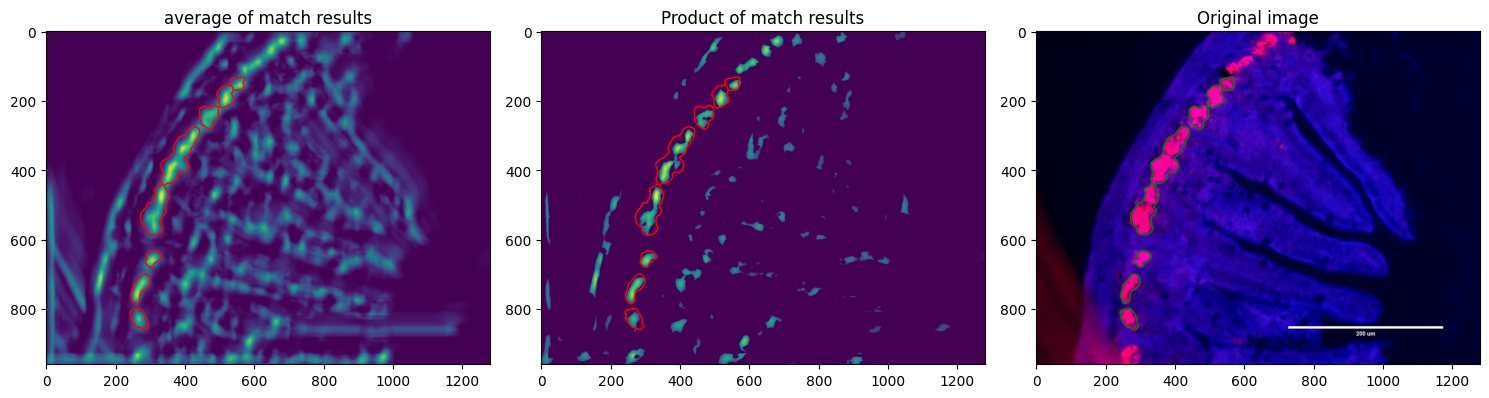

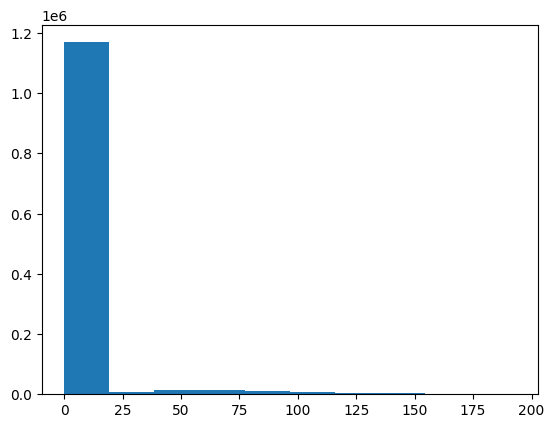

In [242]:
from scipy.stats import gmean

fig, ax = plt.subplots(1,3, figsize=(15,5))

avg_results = np.average(result_stack, axis=0)
collapsed_results = gmean(result_stack).astype(np.uint16)
ax[0].imshow(avg_results)
ax[0].set_title("average of match results")
ax[0].contour(boundaries, colors='r', linewidths=0.5)   


ax[1].imshow(collapsed_results)
ax[1].set_title("Product of match results")
ax[1].contour(boundaries, colors='r', linewidths=0.5)
ax[2].imshow(image)
ax[2].set_title("Original image")
ax[2].contour(boundaries, colors='g', linewidths=0.5)
fig.tight_layout()
fig.show()

# plt.imshow(np.multiply.reduce(result_stack))
# plt.contour(boundaries, colors='r', linewidths=0.5)
fig = plt.figure()
plt.hist(collapsed_results.flatten())
fig.show()

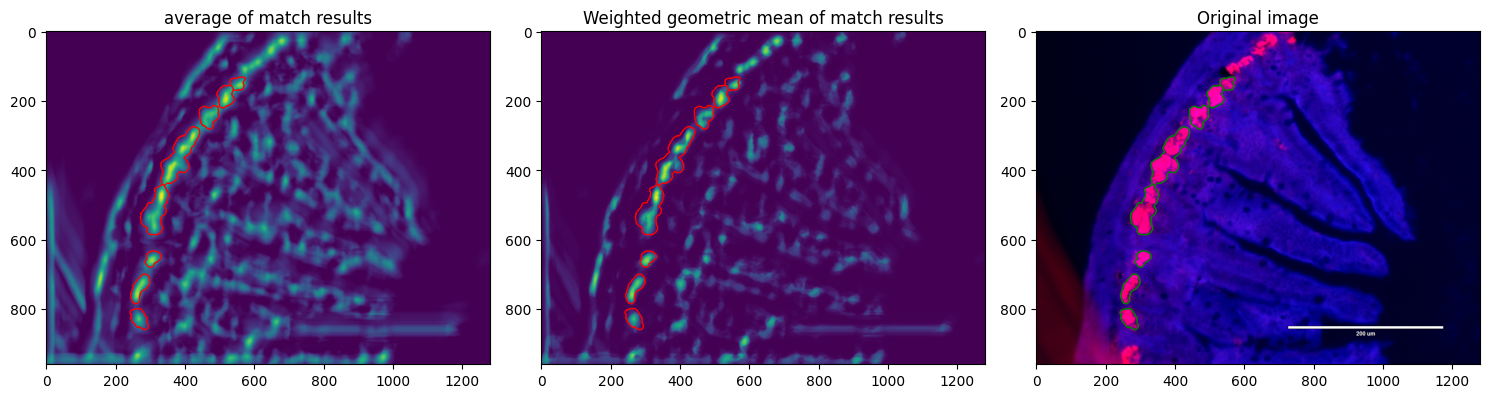

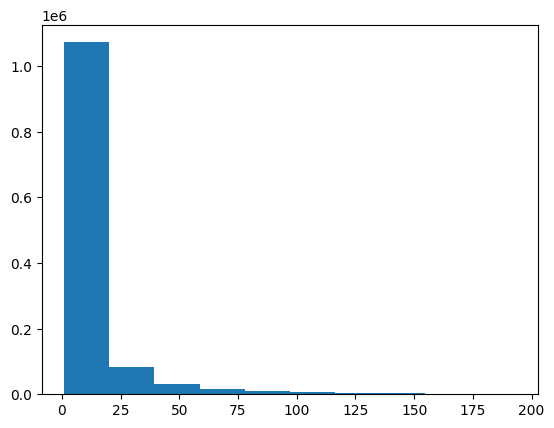

In [241]:
from scipy.stats import gmean

fig, ax = plt.subplots(1,3, figsize=(15,5))

avg_results = np.average(result_stack, axis=0)

# Fix the geometric mean calculation - convert result_stack to proper numpy array first
result_array = np.array(result_stack)
weights_array = np.array(crypt_scores['properties_df']['quality_score'])

# Calculate weighted geometric mean manually since gmean with weights is having broadcasting issues
# Use the formula: exp(sum(w_i * log(x_i)) / sum(w_i))
log_results = np.log(np.maximum(result_array, 1))  # avoid log(0)
weighted_log_sum = np.sum(weights_array[:, np.newaxis, np.newaxis] * log_results, axis=0)
weight_sum = np.sum(weights_array)
collapsed_results = np.exp(weighted_log_sum / weight_sum).astype(np.uint16)

ax[0].imshow(avg_results)
ax[0].set_title("average of match results")
ax[0].contour(boundaries, colors='r', linewidths=0.5)   


ax[1].imshow(collapsed_results)
ax[1].set_title("Weighted geometric mean of match results")
ax[1].contour(boundaries, colors='r', linewidths=0.5)
ax[2].imshow(image)
ax[2].set_title("Original image")
ax[2].contour(boundaries, colors='g', linewidths=0.5)
fig.tight_layout()
fig.show()

# plt.imshow(np.multiply.reduce(result_stack))
# plt.contour(boundaries, colors='r', linewidths=0.5)
fig = plt.figure()
plt.hist(collapsed_results.flatten())
fig.show()

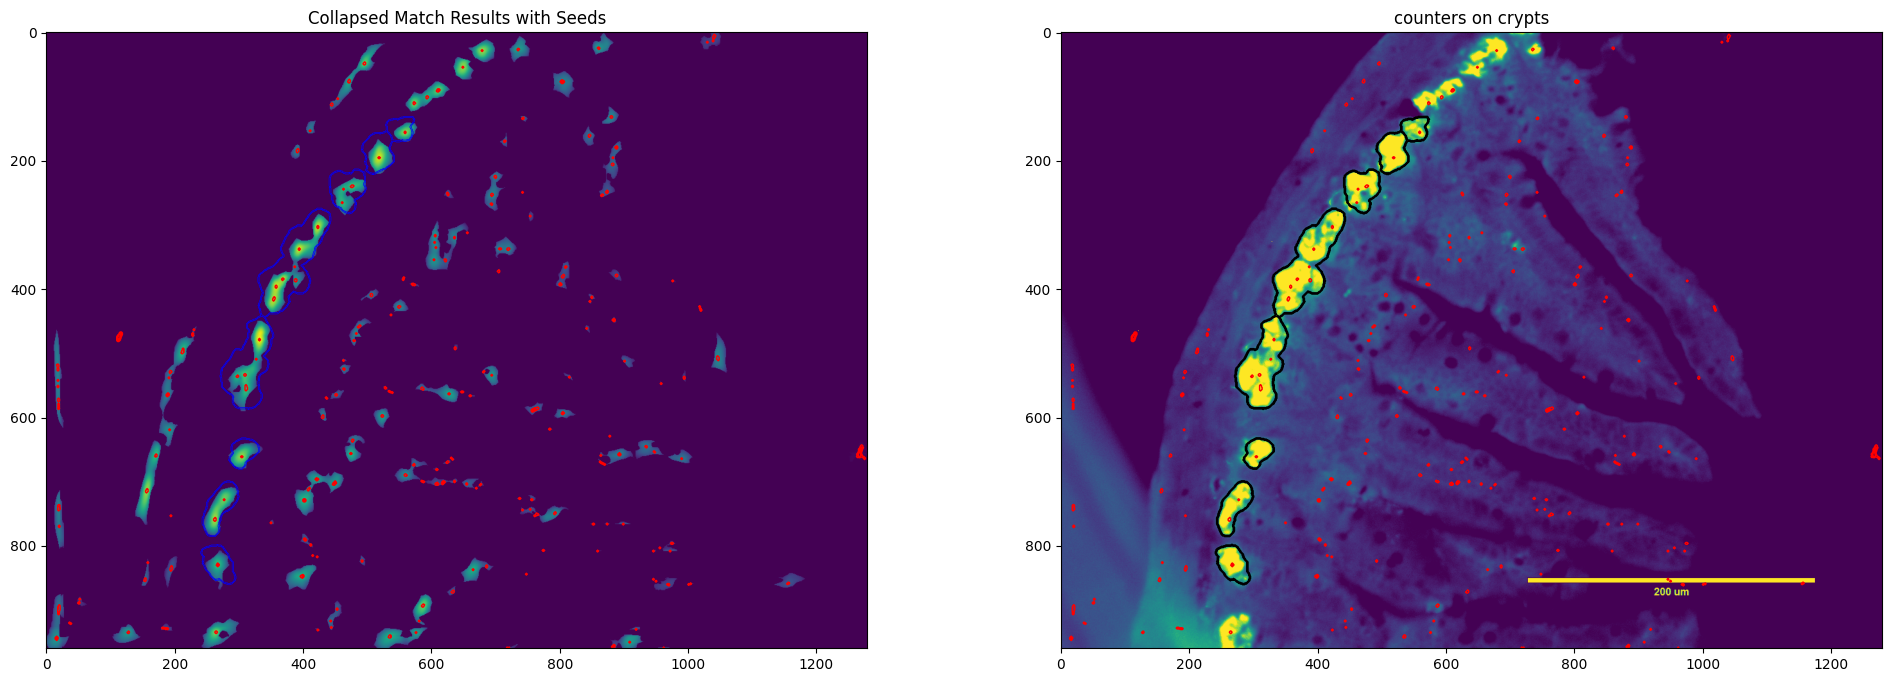

In [243]:
from skimage.morphology import local_maxima, dilation, disk, label, binary_closing,erosion,closing, local_maxima
from skimage.segmentation import watershed
from skimage.util import invert
from scipy.ndimage import distance_transform_edt as dst
from skimage.feature import peak_local_max
seeds = local_maxima(collapsed_results,connectivity=2)
indiv_seeds = label(closing(seeds, disk(4)))

fig, ax = plt.subplots(1,2, figsize=(24,8))
ax[0].imshow(collapsed_results)
ax[0].contour(boundaries, colors='b', linewidths=0.5)

ax[0].contour(find_boundaries(indiv_seeds), colors='r', linewidths=1)
ax[0].set_title('Collapsed Match Results with Seeds')


ax[1].set_title('counters on crypts')
ax[1].imshow(rfp)
ax[1].contour(boundaries, colors='black', linewidths=1)
ax[1].contour(find_boundaries(indiv_seeds), colors='red', linewidths=1)

# ax[1].imshow(label2rgb(watershed(
#     markers=label(seeds, connectivity=2),
#     image=best_crypts==0,
#     mask=best_crypts>0,)))
plt.show()
# try watershed_ift

(array([1.168647e+06, 6.982000e+03, 1.268500e+04, 1.359000e+04,
        1.070600e+04, 7.313000e+03, 4.655000e+03, 2.687000e+03,
        1.270000e+03, 2.650000e+02]),
 array([  0. ,  19.2,  38.4,  57.6,  76.8,  96. , 115.2, 134.4, 153.6,
        172.8, 192. ]),
 <BarContainer object of 10 artists>)

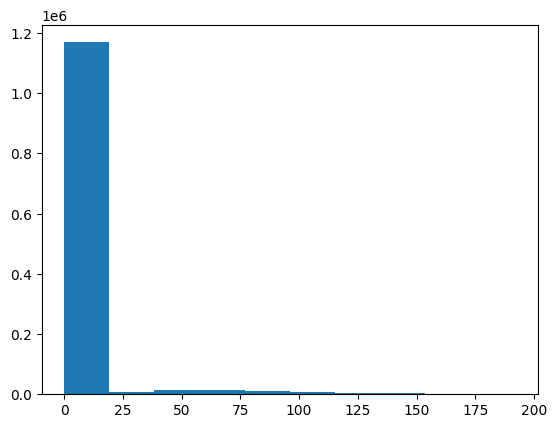

In [188]:
plt.hist(collapsed_results.flatten())

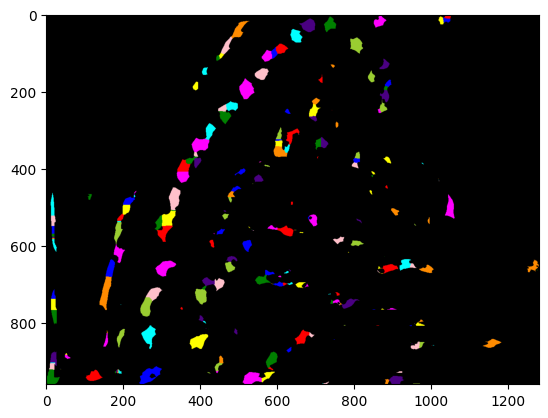

In [245]:
plt.imshow(label2rgb(watershed(
    markers = indiv_seeds,
    image = invert(collapsed_results),
    mask = collapsed_results>0,

)))
    #label2rgb(label(seeds>0)))

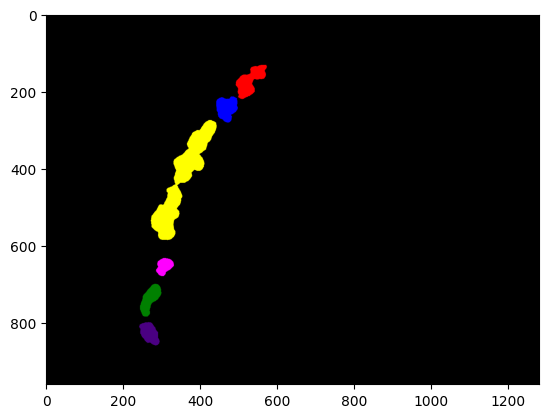

In [131]:
plt.imshow(label2rgb(label(watershed(
    markers=seeds>0,
    image=invert(collapsed_results),
    mask=best_crypts>0,
    watershed_line=True
    ))))


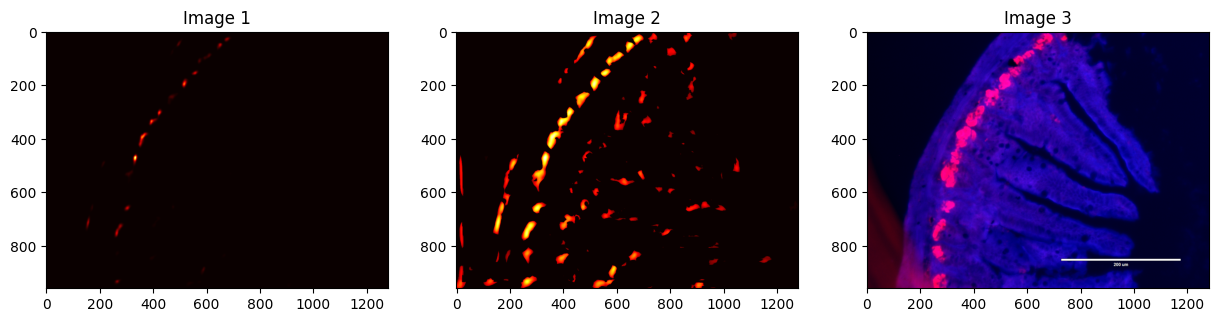

In [85]:
from skimage.morphology import dilation, erosion, disk
from skimage.util import img_as_int

def dynamic_show(images: list[np.ndarray]):
    fig, ax = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='hot')
        ax[i].set_title(f"Image {i+1}")
    plt.show()

results_geometric = gmean(
    img_as_int(np.maximum(result_stack, 0))
    , axis=0)

dynamic_show([img_as_int(collapsed_results), results_geometric, image])

In [84]:
from skimage.morphology import  local_maxima
plt.hist(collapsed_results.ravel(), bins=50)
plt.show()
plt.imshow(, cmap='hot')

SyntaxError: invalid syntax (1951340483.py, line 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


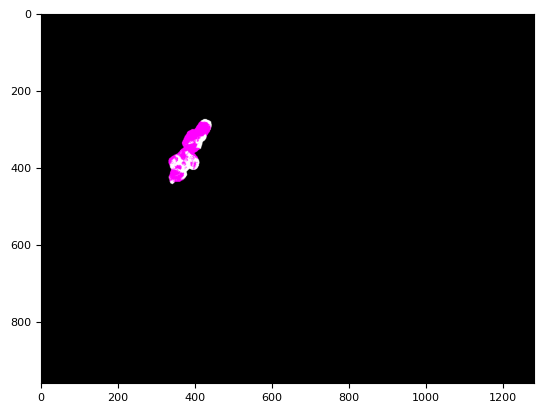

In [ ]:
def autocrop_whitespace(img, template):
    # mask of *content* pixels (not near-white)
    
    # if img.ndim == 3:
    #     content = ~(img >= 255 - tol).all(axis=-1)
    # else:
    #     content = img < 255 - tol
    # slc = ndi.find_objects(content.astype(np.uint8))[0]
    # return np.nan_to_num(img[slc], nan=0)
    slc = ndi.find_objects(template)



# maps:
template_index = 1
template = np.where(best_crypts==1, 1, np.nan)

binary_template = autocrop_whitespace(template)
rfp_template = autocrop_whitespace(rfp * template)
rgb_template = autocrop_whitespace(image * np.dstack([template]*3))


plt.imshow(rgb_template)

In [ ]:
import numpy as np
from scipy import ndimage as ndi

def autocrop_whitespace(img, tol=10):
    # mask of *content* pixels (not near-white)
    if img.ndim == 3:
        content = ~(img >= 255 - tol).all(axis=-1)
    else:
        content = img < 255 - tol
    slc = ndi.find_objects(content.astype(np.uint8))[0]
    return img[slc]

template = np.where((best_crypts==4)[...,None], image,[[[0,0,0]]])
template = autocrop_whitespace(template, tol=10)
template = np.nan_to_num(template, nan=0)
from skimage.feature import match_template
result = match_template(image, template, pad_input=False)
fig, ax = plt.subplots(1,2, figsize=(6,12))
ax[0].imshow(template); ax[0].set_title("template Image")
ax[1].imshow(rfp, cmap="viridis"); ax[1].set_title("Template Matching Result")
plt.show()
plt.imshow(result, cmap="viridis"); plt.title("Template Matching Result"); plt.show()
plt.show()

print("Max match value:", np.max(result))

KeyboardInterrupt: 

In [ ]:
import numpy as np
from scipy import ndimage as ndi

def autocrop_whitespace(img, tol=10):
    # mask of *content* pixels (not near-white)
    if img.ndim == 3:
        content = ~(img >= 255 - tol).all(axis=-1)
    else:
        content = img < 255 - tol
    slc = ndi.find_objects(content.astype(np.uint8))[0]
    return np.nan_to_num(img[slc], nan=0)

template = np.where((best_crypts==4)[...,None], 1, np.nan)
template = autocrop_whitespace(template, tol=10)
template = np.nan_to_num(template, nan=0)
from skimage.feature import match_template
result = match_template(regions, template, pad_input=False)
fig, ax = plt.subplots(1,2, figsize=(6,12))
ax[0].imshow(template); ax[0].set_title("template Image")
ax[1].imshow(rfp, cmap="viridis"); ax[1].set_title("Template Matching Result")
plt.show()
plt.imshow(result, cmap="viridis"); plt.title("Template Matching Result"); plt.show()
plt.show()

print("Max match value:", np.max(result))

ValueError: Dimensionality of template must be less than or equal to the dimensionality of image.